In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score
# Use GridSearchCV to find the best parameters for the model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, RocCurveDisplay, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from xgboost import XGBClassifier

# Anomaly Detection using One class SVM

## Pre-process data

In [64]:
df = pd.read_csv('data_cleaned.csv')

df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target
0,0,2,23,9,302,1023,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0
1,0,3,41,9,48,48,0,0,0,0,...,9,0.08,0.02,0.08,0.00,0.0,0.0,0.0,0.0,0
2,0,2,23,9,334,2096,0,0,0,0,...,255,1.00,0.00,0.03,0.03,0.0,0.0,0.0,0.0,0
3,0,2,23,9,211,1796,0,0,0,0,...,255,1.00,0.00,0.05,0.04,0.0,0.0,0.0,0.0,0
4,0,2,23,9,210,396,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0


In [65]:
# process data, 1: normal; [0, 3, 4] -> -1: abnormal
df['target'] = df['target'].apply(lambda x: -1 if x==1  else 1)
# keep only the columns ['duration', 'protocol_type', 'service', 'src_bytes', 'hot', 'num_failed_logins', 'srv_count', 'same_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_serror_rate']
df = df[['duration', 'protocol_type', 'service', 'src_bytes', 'hot', 'num_failed_logins', 'srv_count', 'same_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_serror_rate', 'target']]
# count values of each target
df['target'].value_counts()

 1    206854
-1     28591
Name: target, dtype: int64

## Split data 
In this part, we are trying to conduct novelty detection, which is a kind of anomaly detection: https://scikit-learn.org/stable/modules/outlier_detection.html#outlier-detection
Use normal data as the training data, and abnormal data + normal data as the testing data

In [66]:
# split data into train and test


# get normal and abnormal data in df
y = df[df['target'] == 1]['target']
X = df[df['target'] == 1].drop(['target'], axis=1, inplace=False)

y_outlier = df[df['target'] == -1]['target']
X_outlier = df[df['target'] == -1].drop(['target'], axis=1, inplace=False)

# split data into train and test
# 50% normal only data for training
X_train, X_test_normal, y_train, y_test_normal = train_test_split(X, y, test_size=0.3, random_state=42)

# 50% normal + 50% abnormal data for testing
_, X_test_ab, _, y_test_ab = train_test_split(X_outlier, y_outlier, test_size=0.5, random_state=42)

# # # prepare data for testing
X_test = pd.concat([X_test_normal, X_test_ab])
y_test = pd.concat([y_test_normal, y_test_ab])




## Fine tune model
Use GridSearchCV to fine-tune the model and find the best parameter set.

In [8]:
# only run this if you want to train on a portion of dataset
X_train = X_train.iloc[:5000, :]
y_train = y_train.iloc[:5000]

X_test1 = X_test.iloc[:2500, :]
X_test2 = X_test.iloc[-2500:, :]
y_test1 = y_test.iloc[:2500]
y_test2 = y_test.iloc[-2500:]

X_test = pd.concat([X_test1, X_test2], axis=0)
y_test = pd.concat([y_test1, y_test2], axis=0)

In [9]:
# suppress `zero_division` warning (we are just using normal data to train)
import warnings
warnings.filterwarnings('ignore')

nus = [0.001, 0.01, 0.05, 0.1, 0.25, 0.5]
gammas = [0.005, 0.01, 0.1, 0.25, 0.5, 1]

tuned_parameters = {'kernel' : ['rbf'], 'gamma' : gammas, 'nu': nus}
scores = ['precision', 'recall']


for score in scores:
    clf = GridSearchCV(OneClassSVM(), tuned_parameters, cv=3,
                           scoring=f'{score}', return_train_score=True)

    clf.fit(X_train, y_train)

    resultDf = pd.DataFrame(clf.cv_results_)
    print(resultDf[["mean_test_score", "std_test_score", "params"]].sort_values(by=["mean_test_score"], ascending=False).head())

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)

    mean_test_score  std_test_score  \
0               1.0             0.0   
1               1.0             0.0   
20              1.0             0.0   
21              1.0             0.0   
22              1.0             0.0   

                                            params  
0   {'gamma': 0.005, 'kernel': 'rbf', 'nu': 0.001}  
1    {'gamma': 0.005, 'kernel': 'rbf', 'nu': 0.01}  
20    {'gamma': 0.25, 'kernel': 'rbf', 'nu': 0.05}  
21     {'gamma': 0.25, 'kernel': 'rbf', 'nu': 0.1}  
22    {'gamma': 0.25, 'kernel': 'rbf', 'nu': 0.25}  
Best parameters set found on development set:

{'gamma': 0.005, 'kernel': 'rbf', 'nu': 0.001}
   mean_test_score  std_test_score  \
3         0.794399        0.005430   
2         0.777595        0.017440   
1         0.756602        0.011138   
9         0.734196        0.016270   
4         0.727597        0.012566   

                                          params  
3   {'gamma': 0.005, 'kernel': 'rbf', 'nu': 0.1}  
2  {'gamma': 0.005, 'k

## Train the model with the best parameter set

In [82]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def train_classifier(models, X_train, y_train, X_test, y_test):
    model_name, model = models
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    classification = metrics.classification_report(y_test, y_pred)
    print()
    print(f"============================== {model_name} Model Evaluation ==============================")
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Classification report:" "\n", classification) 
    print()
    
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=[1, -1], display_labels=['Normal', 'Abormal'])
    # remove grid lines
    plt.tick_params(axis=u'both', which=u'both',length=0)
    plt.grid(b=None)
    plt.show()
    return y_pred

In [47]:
model = OneClassSVM(kernel = 'rbf', gamma = 0.005, nu = 0.1).fit(X_train)
# predict normal and abnormal data
y_pred = model.predict(X_test)

In [48]:
accuracy_score(y_test, y_pred)

0.8942


============================== OneClassSVM Model Evaluation ==============================

Model Accuracy:
 0.11140527224849223

Classification report:
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00     62073
           1       0.12      0.92      0.22      8561

    accuracy                           0.11     70634
   macro avg       0.04      0.31      0.07     70634
weighted avg       0.02      0.11      0.03     70634




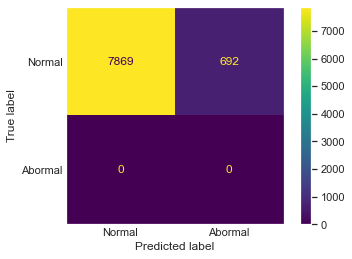

In [83]:
model = OneClassSVM(kernel = 'rbf', gamma = 0.001, nu = 0.1)

y_pred = train_classifier(('OneClassSVM', model), X_train, y_train, X_test, y_test)

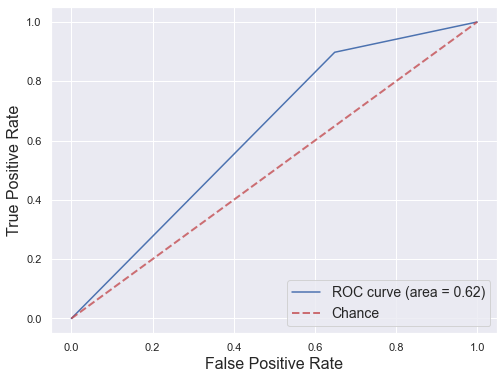

In [69]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# then you can plot(fpr, tpr) to get the roc curve and compute the AUC with:
AUC = auc(fpr, tpr)
fig, ax = plt.subplots(figsize=(8,6))
# plot the roc curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % AUC)
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
# set x label as false positive rate
ax.set_xlabel("False Positive Rate", fontsize=16)
# set y label as true positive rate
ax.set_ylabel("True Positive Rate", fontsize=16)
# set legend 
ax.legend(loc="lower right", fontsize=14)
plt.show()




## Misused Detection (Machine Learning Algorithms)

In [70]:
df = pd.read_csv('data_cleaned.csv')
# keep only the columns ['duration', 'protocol_type', 'service', 'src_bytes', 'hot', 'num_failed_logins', 'srv_count', 'same_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_serror_rate']
df = df[['duration', 'protocol_type', 'service', 'src_bytes', 'hot', 'num_failed_logins', 'srv_count', 'same_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_serror_rate', 'target']]
df.head()

,duration,protocol_type,service,src_bytes,hot,num_failed_logins,srv_count,same_srv_rate,dst_host_same_src_port_rate,dst_host_srv_serror_rate,target
0,0,2,23,302,0,0,9,1.0,0.00,0.0,0
1,0,3,41,48,0,0,1,1.0,0.08,0.0,0
2,0,2,23,334,0,0,8,1.0,0.03,0.0,0
3,0,2,23,211,0,0,19,1.0,0.05,0.0,0
4,0,2,23,210,0,0,10,1.0,0.00,0.0,0


In [71]:
# 0 for normal conn., 1 for abnormal conn.
y = df['target']
X = df.drop(['target'], axis=1)

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [72]:

def train_classifier(models, X_train, y_train, X_test, y_test):
    model_name, model = models
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores = cross_val_score(model, X_train, y_train, cv=10)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    classification = metrics.classification_report(y_test, y_pred)
    print()
    print(f"============================== {model_name} Model Evaluation ==============================")
    print()
    print ("Cross Validation Mean Score:" "\n", scores.mean())
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Classification report:" "\n", classification) 
    print()
    
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=[0, 1], display_labels=['Normal', 'Abnormal'])
    # remove grid lines
    plt.tick_params(axis=u'both', which=u'both',length=0)
    plt.grid(b=None)
    plt.show()
    return y_pred


In [76]:
# function to plot roc curve
def plot_kfold_roc_curve(classifier,X,y,title):

    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(n_splits=5)

    # defining the lists
    tprs = []
    aucs = []
    f1s = []
    mean_fpr = np.linspace(0, 1, 100)
    
    fig, ax = plt.subplots(figsize=(8,6))
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X.iloc[train], y.iloc[train].values.ravel())
        # Compute ROC curve and area under the curve (roc/auc)
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X.iloc[test],
            y.iloc[test],
            name=f"ROC fold {i}",
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        y_pred = classifier.predict(X.iloc[test])
        f1s.append(f1_score(y_true = y.iloc[test],y_pred = y_pred))
    print(f"average f1 score is: {sum(f1s)/len(f1s)}")
    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title=title,
    )
    ax.legend(loc="lower right")
    plt.show()
    

### RandomForest Classifier


============================== Random Forest Model Evaluation ==============================

Cross Validation Mean Score:
 0.9988532333927657

Model Accuracy:
 0.9990372908231163

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     62073
           1       1.00      1.00      1.00      8561

    accuracy                           1.00     70634
   macro avg       1.00      1.00      1.00     70634
weighted avg       1.00      1.00      1.00     70634




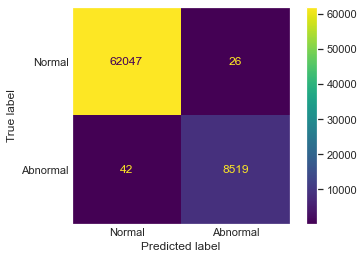

array([0, 0, 0, ..., 0, 1, 0])

In [74]:
train_classifier(("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42)), X_train, y_train, X_test, y_test)

average f1 score is: 0.9957124931396102


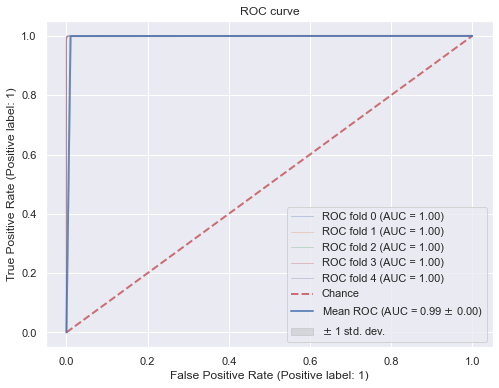

In [78]:
classifier = RandomForestClassifier(n_estimators=100)
plot_kfold_roc_curve(classifier, X, y, title = "ROC curve")

## XGBoost Classifier


============================== XGBoost Model Evaluation ==============================

Cross Validation Mean Score:
 0.9988532308158241

Model Accuracy:
 0.9988674009683721

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     62073
           1       1.00      0.99      1.00      8561

    accuracy                           1.00     70634
   macro avg       1.00      1.00      1.00     70634
weighted avg       1.00      1.00      1.00     70634




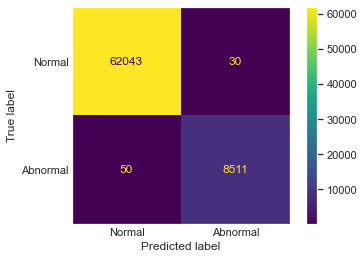

array([0, 0, 0, ..., 0, 1, 0])

In [80]:
# Train XGBoost Classifier
xgbc = XGBClassifier(eval_metric="logloss", random_state=42)

train_classifier(("XGBoost", xgbc), X_train, y_train, X_test, y_test)

average f1 score is: 0.9956955089302909


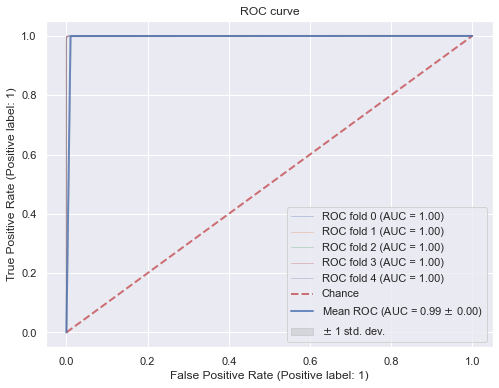

In [81]:
plot_kfold_roc_curve(classifier, X, y, title = "ROC curve")